# Unsupervised Learning with Linear Algebra

In this blog post, I try to experiment with some machine learning approaches to compress some data.

But first we need some data, so I implemented the code below to grab us some from the internet. And specifically, we're gonna need some Data, Crusher, Troi Picard, La Forge, Worf, and Riker.

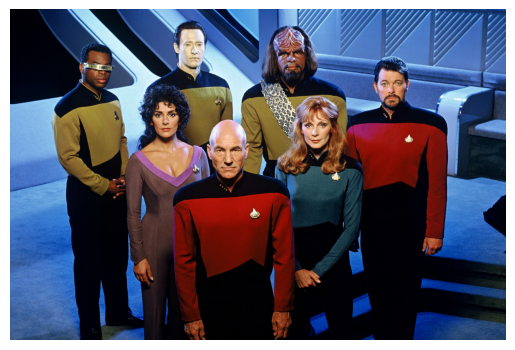

In [1]:
import PIL, urllib
from matplotlib import pyplot as plt
import numpy as np
np.random.seed(1701) # for the NCC-1701

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

url = "https://static.wikia.nocookie.net/memoryalpha/images/2/23/Star_Trek_TNG_cast.jpg/revision/latest?cb=20200323081735&path-prefix=en"
img = read_image(url)
plt.imshow(img); plt.axis("off")
plt.savefig('TNG.png', pad_inches=0)

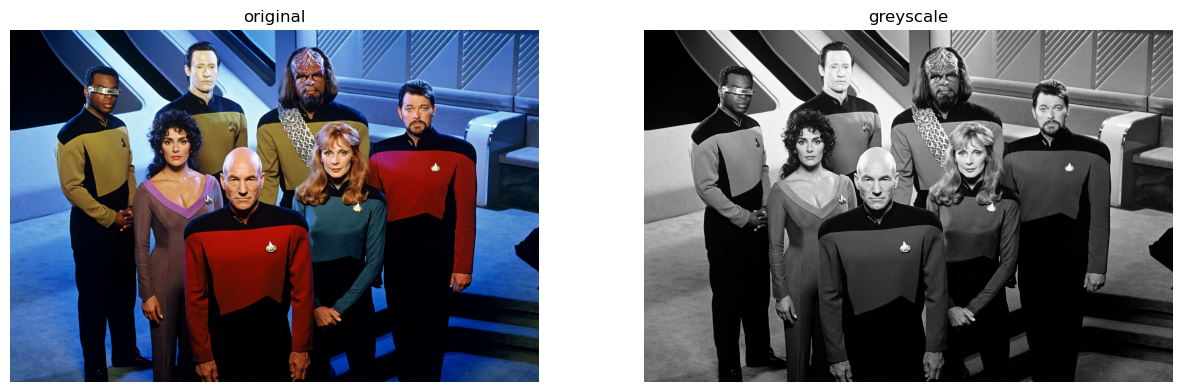

In [2]:
# Set the figure size for the plot
plt.figure(figsize=(15, 5))

# Function to convert an image to grayscale as supplied from the blog docs
def to_greyscale(img):
    return 1 - np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

# Convert the image to grayscale
grey_img = to_greyscale(img)

# Plotting the original image
plt.subplot(121)
plt.imshow(img)
plt.axis("off")
plt.title("original")

# Plotting the grayscale image
plt.subplot(122)
plt.imshow(grey_img, cmap="Greys")
plt.axis("off")
plt.title("greyscale")

# Save the figure as an image file
plt.savefig('TNG.png', pad_inches=0)

## Compression

As you can see, I converted the image to greyscale to help with the later process of compression.

For the sake of this exercise, it will be a lot easier to do with a bunch of single brightness values defining the difference from white to black than working with three separate color values.

Plus it gives it a cool retro vibe :)

***

Now let's get into how I am going to compress this image. I am going to have Captain Picard explain:

<blockquote>
    
## Captain's Log, Stardate 100944.83:

We have made a remarkable discovery regarding the compression of grayscale images. Singular Value Decomposition (SVD) has proven to be a valuable tool in this endeavor. Allow me to elucidate the process:
    
***Step 1: Prepare the Image***
<br>Prepare the grayscale image for compression. This involves converting it to a grayscale format, focusing solely on the shades of gray that shape its essence. The *stellar* code provided above has been implemented to do this for us.

***Step 2: Engage SVD***
<br>Engage the extraordinary power of Singular Value Decomposition. SVD dissects the image into three significant components: U, Sigma, and V. Each element holds crucial information about the image's structure.

***Step 3: Select the Singular Values***
<br>Decisions must be made regarding the number of singular values to retain. This parameter, denoted as K, governs the balance between compression and image fidelity. Choose wisely, as the optimal K will define the outcome.

***Step 4: Precise Approximation***
<br>Utilize the chosen K to create an approximation of the image. By retaining only the most significant singular values and their corresponding components, we achieve a compressed representation of the image while minimizing information loss.

***Step 5: Reconstruct the Image***
<br>Reconstruct the compressed image by combining the retained singular values, their components, and the V matrix. Witness the image emerge, akin to the restoration of a cherished artifact.

***Step 6: Assess the Results***
<br>Evaluate the compression achieved, considering storage requirements and image quality. Balance is key, for a successful compression strikes a harmonious chord between compactness and faithful representation.

Through this application of Singular Value Decomposition, we unveil a new avenue for grayscale image compression. This technique empowers us to reduce data while preserving the image's essential characteristics. *A remarkable voyage indeed.*

### Captain Jean-Luc Picard, out.
</blockquote>

In [3]:
import numpy as np
import warnings

def svd_reconstruct(img, num_sv=10, comp_factor=0, threshold=0):
    # Get the dimensions of the image
    m, n = img.shape
    data = np.array(img)  # Convert the image to a numpy array

    # Calculate the number of singular values (num_sv) if a compression factor (comp_factor) is specified
    if comp_factor != 0:
        num_sv = int((comp_factor * n * m) / (n + m + 1))

    # Check if num_sv is larger than the dimensions of the image and adjust if necessary
    if num_sv > m or num_sv > n:
        warnings.warn("WARNING: num_sv does not fit dimensions of img")
        num_sv = min(n, m)

    # Perform singular value decomposition (SVD) on the image data
    U, sigma, V = np.linalg.svd(data)

    # Create a diagonal matrix D with singular values
    D = np.zeros_like(data, dtype=float)
    D[:min(data.shape), :min(data.shape)] = np.diag(sigma)

    # Determine the components for approximation based on whether a threshold is specified or not
    if threshold == 0:
        U_ = U[:, :num_sv]
        D_ = D[:num_sv, :num_sv]
        V_ = V[:num_sv, :]
    else:
        # Count the number of singular values larger than the threshold
        new_num_sv = np.count_nonzero(D > threshold)

        # Adjust new_num_sv if it exceeds the image dimensions
        if new_num_sv > m or new_num_sv > n:
            new_num_sv = min(n, m)

        # Use new_num_sv if it is smaller than the specified components (num_sv)
        if new_num_sv < num_sv:
            num_sv = new_num_sv

        U_ = U[:, :num_sv]
        D_ = D[:num_sv, :num_sv]
        V_ = V[:num_sv, :]

    # Reconstruct the image using the selected components
    data_ = U_ @ D_ @ V_

    # Calculate the storage size and compression ratio
    storage = (m * num_sv + num_sv + num_sv * n)
    fraction = storage / (n * m)

    return data_, round(fraction * 100, 2)

I implemented the code above using the examples provided in blog post documentation and help hours. I call the K constant "num_sv" as it represents the number of singular values to be retained and used in our compression factors. Otherwise, the comments are pretty self explanatory, where the svd_reconstruct function takes a grayscale image and performs singular value decomposition on it. It allows for compression of the image by retaining a specified number of singular values or by applying a threshold to select significant singular values, and returns the reconstructed image along with the storage size and compression ratio. Next let's look at a quick comparison.

In [4]:
def compare_svd_reconstruct(img, num_sv=10, comp_factor=0, threshold=0):
    # Convert the input image to a numpy array
    A = np.array(img)

    # Reconstruct the image using singular value decomposition (SVD)
    A_, storage_percent = svd_reconstruct(A, num_sv, comp_factor=comp_factor, threshold=threshold)

    # Get the dimensions of the original image
    m, n = A.shape

    # Create a figure with two subplots for comparing the original and reconstructed images
    fig, axarr = plt.subplots(1, 2, figsize=(18, 9))

    # Display the original image in the first subplot
    axarr[0].imshow(A, cmap="Greys")
    axarr[0].axis("off")
    axarr[0].set(title="original greyscale image")

    # Display the reconstructed image in the second subplot
    axarr[1].imshow(A_, cmap="Greys")
    axarr[1].axis("off")
    img_title = "reconstructed image\n" + str(storage_percent) + "% storage"
    axarr[1].set(title=img_title)


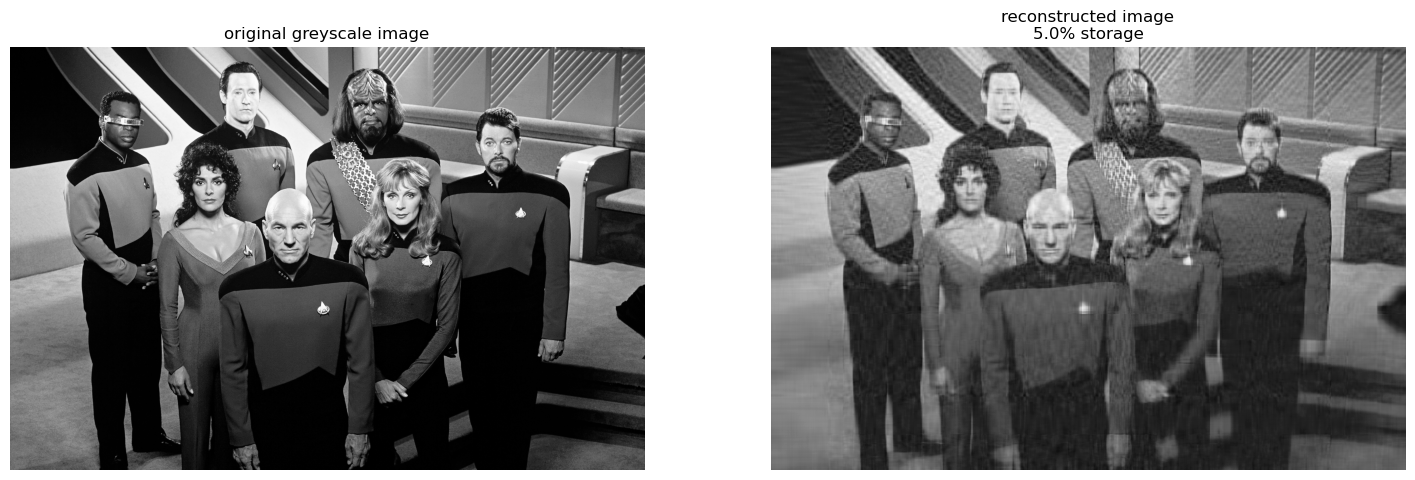

In [5]:
compare_svd_reconstruct(to_greyscale(img), 50)

In [ ]:
compare_svd_reconstruct(to_greyscale(img), 50)

We can see here that this number of components used to compress the image (50) is probably not enough. So let's run some experiments to see what might be a good number of singular values for our compression.

In [6]:
def svd_experiment(img):
    rows = 5
    columns = 3

    # Create a figure with subplots for displaying the results
    fig, axarr = plt.subplots(rows, columns, figsize=(20, 25))

    # Iterate over the rows and columns of the subplots
    for i in range(rows):
        for j in range(columns):
            # Determine the number of components (k) based on the current row and column
            k = (i * 4 + j + 1) * 15

            # Reconstruct the image using the specified number of components
            A_, storage_percent = svd_reconstruct(img, k)

            # Create a title for the subplot indicating the number of components and storage percentage
            img_title = str(k) + " components\n" + str(storage_percent) + "% storage"

            # Display the reconstructed image in the current subplot
            axarr[i][j].imshow(A_, cmap="Greys")
            axarr[i][j].axis("off")
            axarr[i][j].set(title=img_title)

    # Adjust the spacing between subplots
    fig.tight_layout()

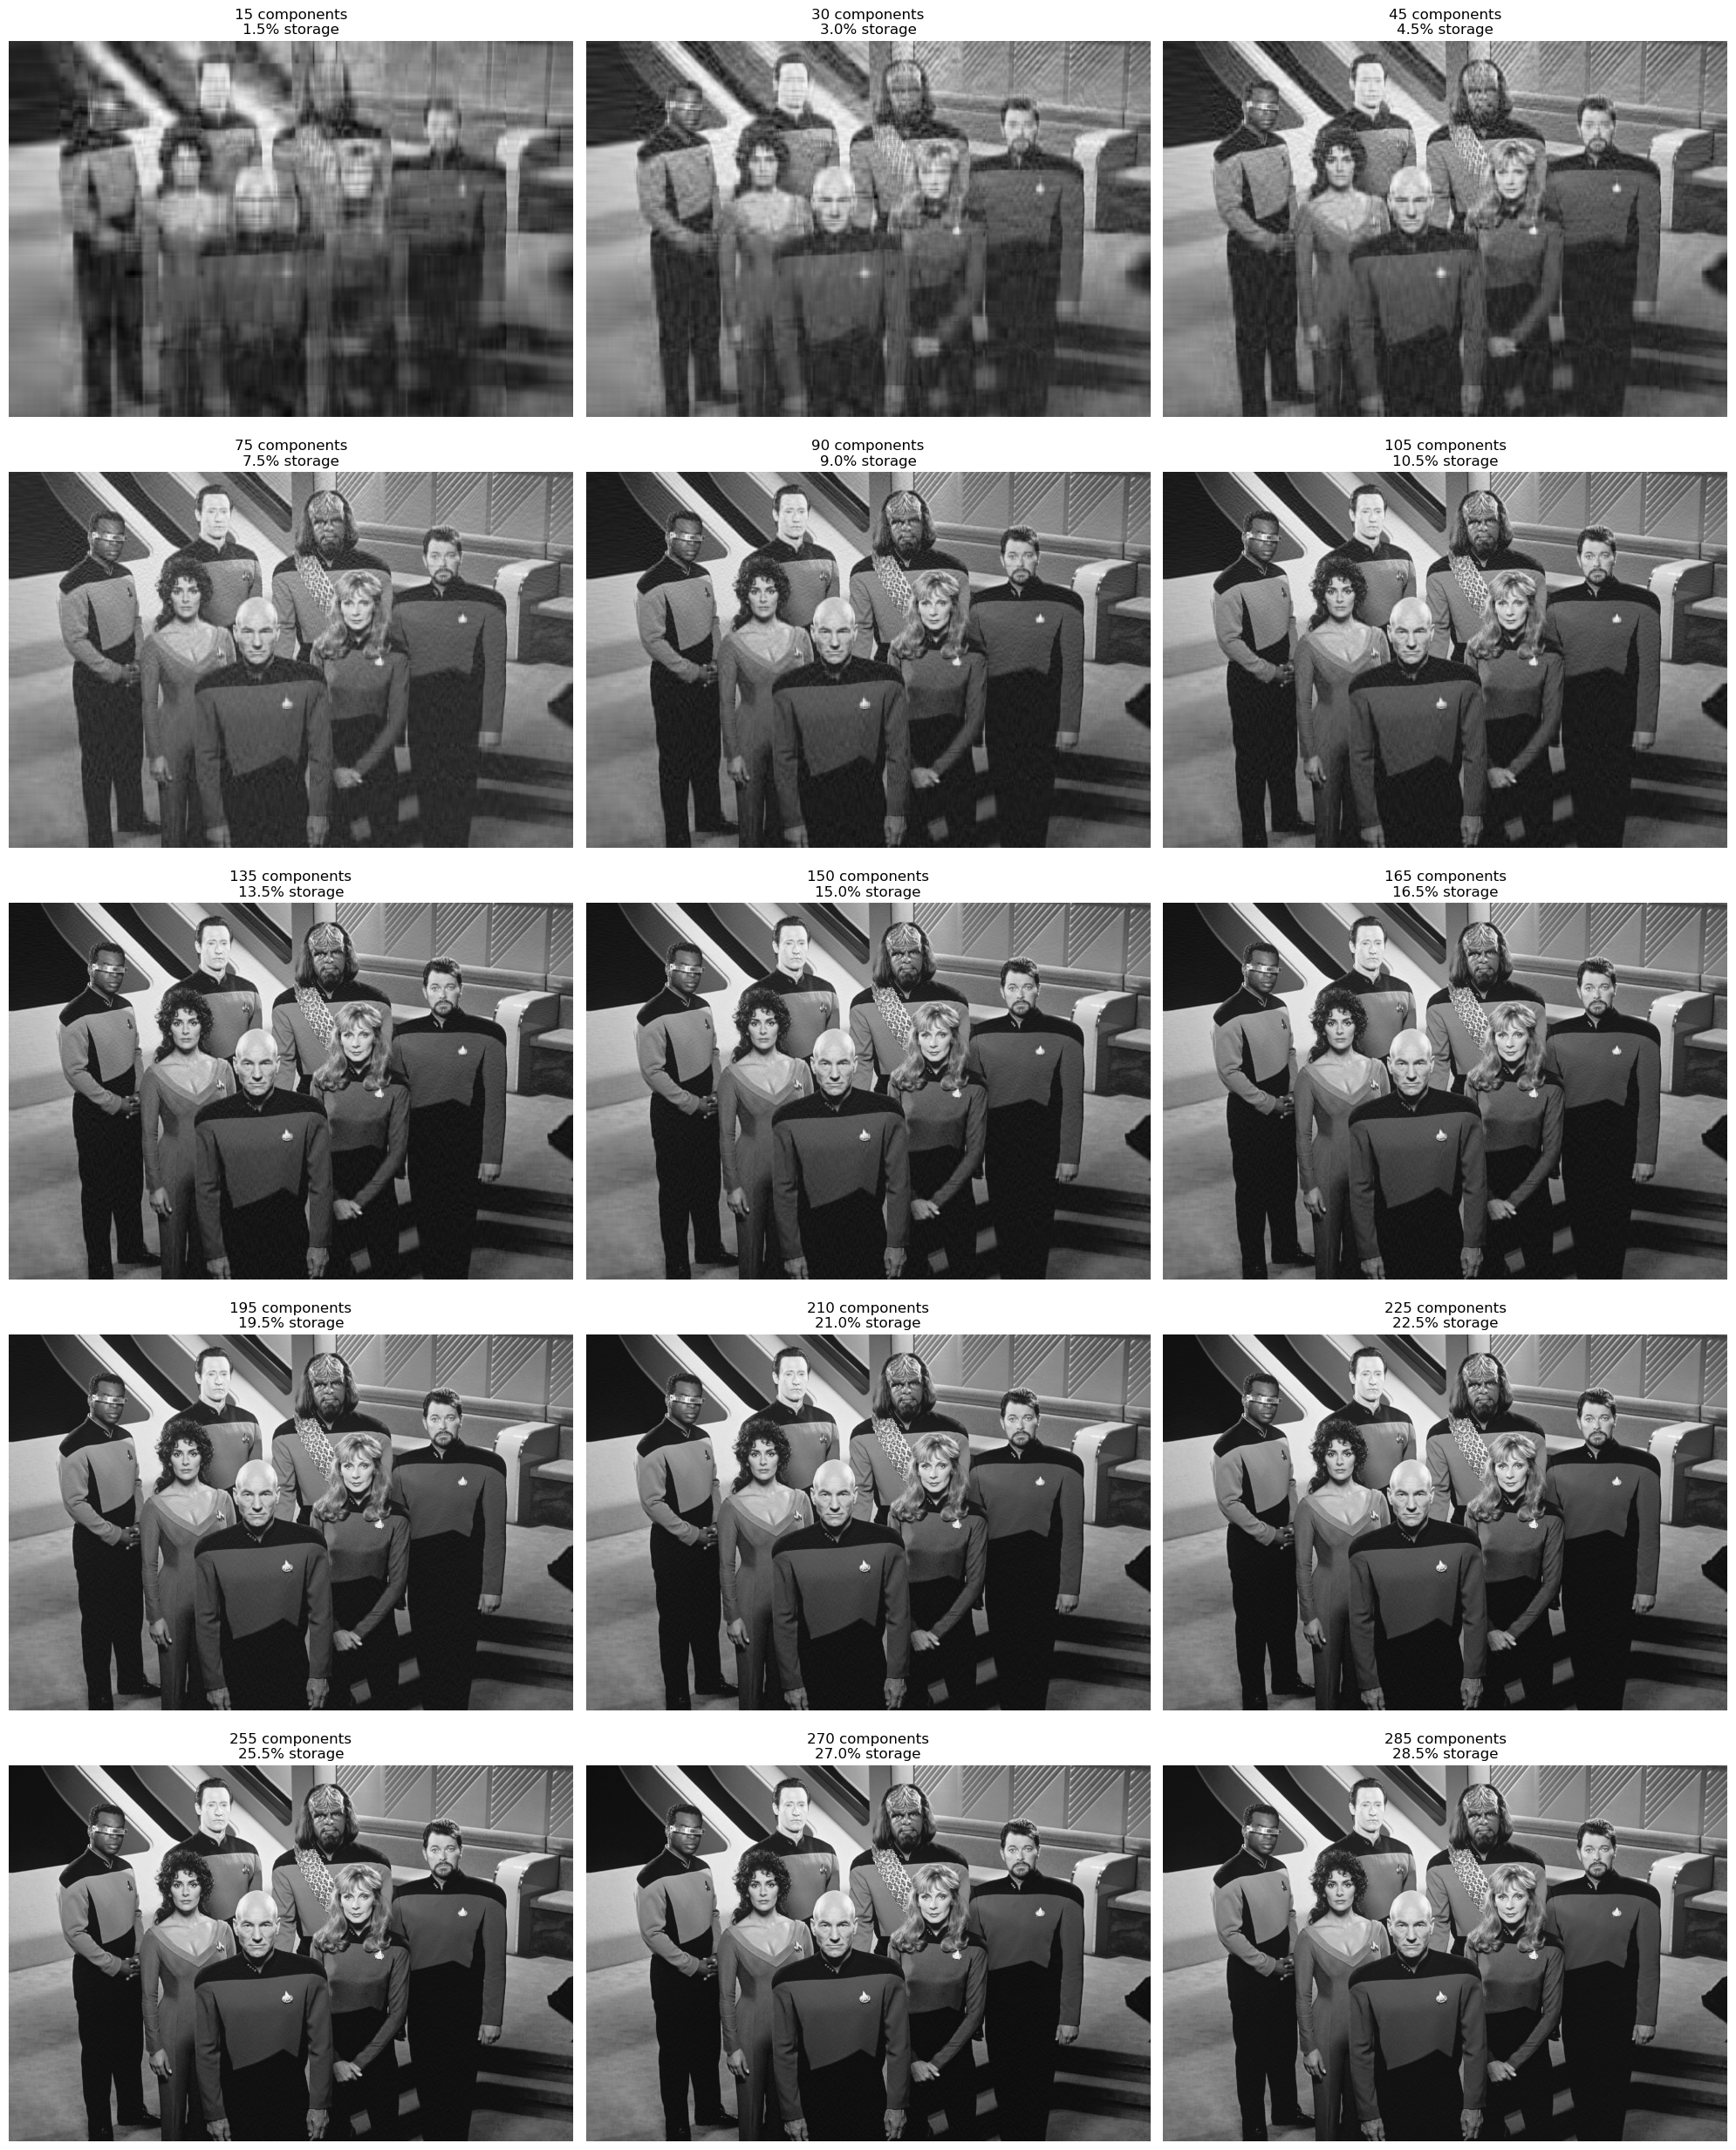

In [7]:
svd_experiment(to_greyscale(img))
plt.savefig('experiment.png')

Now we're getting somewhere. The first few tests clearly have too few SVs, but by the 2nd row, much of the image is already there. And by the 3rd or 4th row, the compression artifacts created by our method are much less distracting and the image is difficult to discern from the original without pixel peeping. This is particularly noticeable on the crew's clothing, where the compression has a hard time doing smooth gradients. By around 225 components would be where I draw the line:

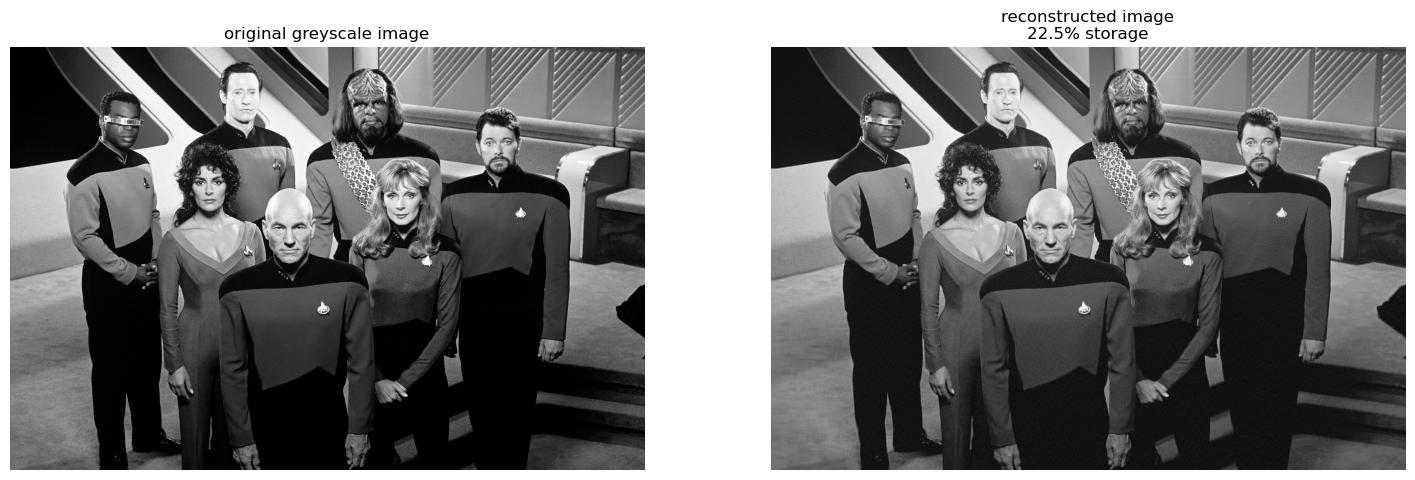

In [8]:
compare_svd_reconstruct(to_greyscale(img), 225)

*Indeed,* by utilizing singular value decomposition (SVD) for image compression, we can significantly reduce the size of the image while preserving its essential features. This method works well for compressing this image of TNG crew, but we may have to tweak it in the future for other uses. In my estimate, achieving a compression down to approximately 23% of the original size demonstrates the effectiveness of SVD-based compression in reducing storage requirements without sacrificing essential image quality.